In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 6: Clustering
### Associated lectures: Lectures 15 and 16

**Due date: [Mar 17, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative)**

## Imports <a name="im"></a>

In [2]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:6}

**Please be aware that this homework assignment requires installation of several packages in your course environment. It's possible that you'll encounter installation challenges, which might be frustrating. However, remember that solving these issues is not wasting time but it is an essential skill for anyone aspiring to work in data science or machine learning.**

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 4. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb. If the pdf or html also fail to render on Gradescope, please create two files for your homework: hw6a.ipynb with Exercise 1 and hw6b.ipynb with Exercises 2 and 3 and submit these two files in your submission.  
</div>

_Points:_ 6

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 1: Document clustering warm-up
<hr>

In this homework, we will explore a popular application of clustering called [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A, tweets), and clustering is a commonly used technique to organize this data in a meaningful way. 

As a warm up, in this exercise you will cluster sentences from a toy corpus. Later in the homework you will work with a real corpus. 

The code below extracts introductory sentences of Wikipedia articles on a set of queries. To run the code successfully, you will need the `wikipedia` package installed in the course environment. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```


**Your tasks:**

Run the code below which 
- extracts content of Wikipedia articles on a set of queries
- tokenizes the text (i.e., separates sentences) and 
- stores the 2nd sentence in each article as a document representing that article

> Feel free to experiment with Wikipedia queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs to grade your submission.

> For tokenization we are using the `nltk` package. If you do not have this package in the course environment, you will have to install it.

```
conda activate cpsc330
conda install -c anaconda nltk
```

Even if you have the package installed via the course `conda` environment, you might have to download `nltk` pre-trained models, which can be done with the code below.

In [3]:
import nltk

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "baguette food",
    "banana bread food",
    "bread food",
    "data science",
    "sports analytics",
    "football sport",
    "ice hockey",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    text = sent_tokenize(wikipedia.page(queries[i]).content)[1]
    wiki_dict["text"].append(text)
    wiki_dict["n_words"].append(len(word_tokenize(text)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,baguette food,It is distinguishable by its length and crisp crust.,10
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diets.",20
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17
6,ice hockey,It belongs to a family of sports called hockey.,10


Our toy corpus has six toy documents (`text` column in the dataframe) extracted from Wikipedia queries. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many clusters? 
rubric={points}


**Your tasks:**

1. If you are asked to cluster the documents from this toy corpus manually, how many clusters would you identify and how would you label each cluster?   

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 1

Most likely I would split the toy corpus into 3 different clusters where the first cluster stores information about food, data, and sports. The first cluster would contain the food options from rows 0-2. The second cluster about data would be rows 3-4, and the final cluster about sports would be rows 5-6.  

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 `KMeans` with bag-of-words representation 
rubric={points}

In the lecture, we saw that data representation plays a crucial role in clustering. Changing flattened representation of images to feature vectors extracted from pre-trained models greatly improved the quality of clustering. 

What kind of representation is suitable for text data? We have used bag-of-words representation to numerically encode text data before, where each document is represented with a vector of word frequencies. 

Let's try clustering documents with this simplistic representation.  

**Your tasks:**

1. Create bag-of-words representation using [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with default arguments for the `text` column in `wiki_df` above.
2. Cluster the encoded documents with [`KMeans` clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Use `random_state=42` (for reproducibility) and set `n_clusters` to the number you identified in the previous exercise.
3. Store the clustering labels in `kmeans_bow_labels` variable below. 

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Step 1: Create bag-of-words representation
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(wiki_df["text"])  # Assuming wiki_df is already defined

# Step 2: Perform KMeans clustering
num_clusters = 3  # Replace with the actual number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_bow)

# Step 3: Store the clustering labels
kmeans_bow_labels = kmeans.labels_

In [6]:
wiki_df["bow_kmeans"] = kmeans_bow_labels
wiki_df

,wiki query,text,n_words,bow_kmeans
0,baguette food,It is distinguishable by its length and crisp crust.,10,0
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,0
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diets.",20,0
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,2
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,0
6,ice hockey,It belongs to a family of sports called hockey.,10,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Sentence embedding representation
rubric={points}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer and more expressive representations of text which can be extracted using transfer learning. In this lab, we will use one such representation called sentence embedding representation, which uses deep learning models to generate dense, fixed-length vector representations for sentences. We will extract such representations using sentence transformer package. Sentence embedding takes into account context of words and semantic meaning of sentences and it is likely to work better when we are interested in clustering sentences based on their semantic similarity. 

```
conda activate cpsc330
conda install pytorch::pytorch torchvision torchaudio -c pytorch
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

1. Run the code below to create sentence embedding representation of documents in our toy corpus. 
2. Cluster documents in our toy corpus encoded with this representation (`emb_sents`) and `KMeans` with following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the clustering labels in `kmeans_emb_labels` variable below. 

In [7]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

# If this cell gives an error, try updating transformers with
# pip install transformers -U

In [8]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.186268,0.286701,0.058714,0.095216,-0.136911,0.091687,-0.029694,-0.104941,0.174888,0.482772,...,0.025579,-0.078821,0.470531,-0.209694,-0.379226,0.409230,-0.299176,0.155533,0.309284,0.124819
1,-0.202058,0.320748,0.190347,0.232201,0.600541,0.376622,-0.018205,-0.027148,-0.076680,0.381883,...,0.213062,-0.080008,0.422756,0.072725,0.016024,-0.014596,-0.202858,-0.162947,-0.190418,-0.002013
2,-0.056684,0.222303,0.048026,0.053723,0.304123,0.396496,-0.000865,-0.261328,0.180089,0.177299,...,0.343994,-0.412435,-0.010878,0.022342,0.371977,0.108193,0.385293,0.147794,-0.077855,0.222680
3,0.270839,0.187923,-0.010779,0.318688,-0.092012,-0.204805,0.038100,-0.117648,0.084057,-0.170613,...,0.069943,-0.222987,0.092472,0.309445,0.289248,0.021022,-0.032693,-0.624041,0.358924,-0.034092
4,-0.101732,-0.185133,-0.107289,0.148191,0.458463,-0.555427,-0.073999,0.001754,-0.172459,-0.072560,...,0.428589,-0.340837,-0.159757,0.388600,0.316263,0.090864,-0.162353,-0.225393,0.417017,-0.179008
5,0.124750,0.327760,0.287334,-0.108246,0.024023,-0.123068,0.256753,-0.186897,0.207025,0.225442,...,0.476354,-0.425226,0.153235,0.176922,0.036421,0.104009,-0.137497,0.265884,0.431444,0.173652
6,0.108902,0.087364,0.119847,-0.050133,0.240210,-0.082101,0.190988,0.436203,-0.085558,-0.012788,...,0.145414,0.160033,0.071930,0.147640,0.043789,0.253031,-0.009358,0.415206,0.142142,0.130365


<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 3

In [9]:
num_clusters = 3  # Replace with the actual number of clusters
kmeans_emb = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_emb.fit(emb_sent_df)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [10]:
kmeans_emb_labels = kmeans_emb.labels_

In [11]:
wiki_df["emb_kmeans"] = kmeans_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans
0,baguette food,It is distinguishable by its length and crisp crust.,10,0,2
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,0,2
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diets.",20,0,0
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,2,1
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1,1
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,0,1
6,ice hockey,It belongs to a family of sports called hockey.,10,0,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 DBSCAN with cosine distance  
rubric={points}

Now try [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text data, [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work well. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$


**Your tasks**

1. Cluster documents in our toy corpus encoded with sentence embedding representation (`emb_sents`) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan#sklearn.cluster.DBSCAN) with `metric='cosine'`. You will have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values of these hyperparameters are unlikely to work well on this toy dataset.
2. Store the clustering labels in the `dbscan_emb_labels` variable below. 

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

In [12]:
from sklearn.cluster import DBSCAN
num_clusters = 3  # Replace with the actual number of clusters
DB_emb = DBSCAN(eps=8, min_samples=2)
DB_emb.fit(emb_sent_df)

DBSCAN(eps=8, min_samples=2)

In [13]:
dbscan_emb_labels = DB_emb.labels_

In [14]:
wiki_df["emb_dbscan"] = dbscan_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan
0,baguette food,It is distinguishable by its length and crisp crust.,10,0,2,0
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,0,2,0
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diets.",20,0,0,-1
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,2,1,1
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1,1,1
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,0,1,1
6,ice hockey,It belongs to a family of sports called hockey.,10,0,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Hierarchical clustering with sentence embedding representation
rubric={points}

**Your tasks:**

Try hierarchical clustering on `emb_sents`. In particular
1. Create and show a dendrogram with `complete` linkage and `metric='cosine'` on this toy dataset.
2. Create flat clusters using `fcluster` with appropriate hyperparameters and store cluster labels to `hier_emb_labels` variable below.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 3

In [15]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

# Step 1: Compute linkage matrix using 'complete' linkage and 'cosine' distance
linkage_matrix = sch.linkage(pdist(emb_sents, metric='cosine'), method='complete')

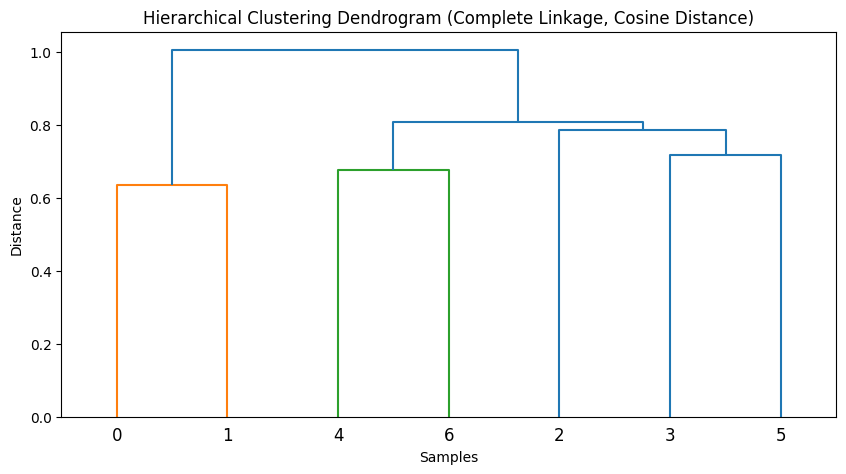

In [16]:
# Step 2: Plot the dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram (Complete Linkage, Cosine Distance)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

num_clusters = 3  # Replace with the appropriate number of clusters
hier_emb_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')


In [17]:
# hier_emb_labels = fcluster(Z, 3, criterion="maxclust") # alternative solution

In [18]:
wiki_df["emb_hierarchical"] = hier_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan,emb_hierarchical
0,baguette food,It is distinguishable by its length and crisp crust.,10,0,2,0,1
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,0,2,0,1
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diets.",20,0,0,-1,3
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,2,1,1,3
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1,1,1,2
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,0,1,1,3
6,ice hockey,It belongs to a family of sports called hockey.,10,0,1,1,2


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.6 Discussion
rubric={points}

**Your tasks:**

1. Reflect on and discuss the clustering results of the methods you explored in the previous exercises, focusing on the following points:    
    - effect of input representation on clustering results
    - whether the clustering results match with your intuitions and the challenges associated with getting the desired clustering results with each method

<div class="alert alert-warning">

Solution_1.6
    
</div>

_Points:_ 4

The results are different from what I expected. The clustering seems to have a large effect on the accuracy of the result and the way that things are clustered, it seems that using embeddings intead of bow can lead to the k_means algorithm discriminating a little better as before the sports rows are in the same cluster as the food, whereas now they are in different groups. Although the clustering results in most of the different strategies do get somewhat close to what I proposed before, there are still discrepencies within each k_means result. This is an inherent feature of k_means as the results depend on initialization and the clustering might be referring to some other relation that I was not able to identify inside of the toy set. 

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 1.7 Visualizing clusters
rubric={points:4}


One approach to working with unlabeled data is visualization. That said, our data is high-dimensional, making it challenging to visualize. Take sentence embedding representation as an example: each instance is depicted in 768 dimensions. To visualize such high-dimensional data, we can employ dimensionality reduction techniques to extract the most significant 2 or 3 components, and then visualize this low-dimensional data.

Given data as a `numpy` array and corresponding cluster assignments, the `plot_umap_clusters` function below transforms the data by applying dimensionality reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to it and plots the transformed data with different colours for different clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the UMAP part.* 

You'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate cpsc330
> conda install -c conda-forge umap-learn
```
or

```
> conda activate cpsc330
> pip install umap-learn 
```

If you get an error with the import below try

```
pip install --upgrade numba umap-learn
```

**Your tasks:**

1. Visualize the clusters created by the methods above using `plot_umap_clusters` function below. In other words, visualize clusters identified by each of the methods below. 
    - K-Means with bag-of-words representation 
    - K-Means with sentence embedding representation
    - DBSCAN with sentence embedding representation 
    - Flat cluster of hierarchical clustering with sentence embedding representation     

In [19]:
import umap


In [20]:
# Removes umap warnings due to a change of API in sklearn.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_umap_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
    ignore_noise=False,
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42, n_jobs=1)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    if ignore_noise:
        umap_df = umap_df[umap_df["cluster"] != -1]

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        #edgecolors="k",
        #linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    if show_labels:
        x = umap_df["dim1"].tolist()
        y = umap_df["dim2"].tolist()
        for i, txt in enumerate(raw_sents):
            ax.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
    plt.show()

<div class="alert alert-warning">

Solution_1.7
    
</div>

_Points:_ 4

/workspaces/cs330-hw6/myenv/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


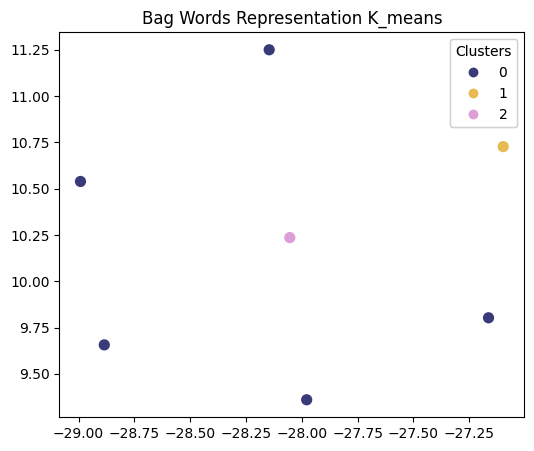

/workspaces/cs330-hw6/myenv/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


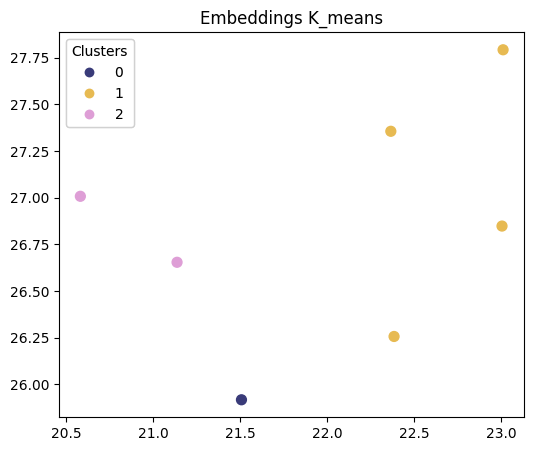

/workspaces/cs330-hw6/myenv/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


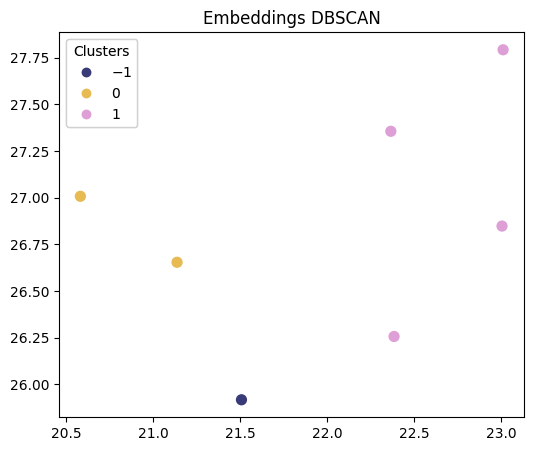

/workspaces/cs330-hw6/myenv/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


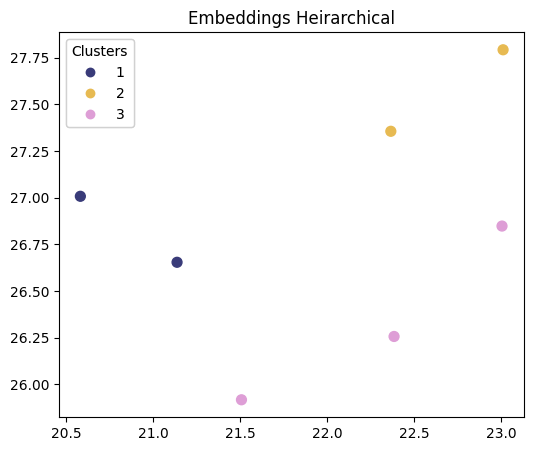

In [21]:
plot_umap_clusters(
    X_bow,
    kmeans.labels_,
    title="Bag Words Representation K_means"
)

plot_umap_clusters(
    emb_sent_df,
    kmeans_emb.labels_,
    title="Embeddings K_means"
)

plot_umap_clusters(
    emb_sent_df,
    dbscan_emb_labels,
    title="Embeddings DBSCAN"
)

plot_umap_clusters(
    emb_sent_df,
    hier_emb_labels,
    title="Embeddings Heirarchical"
)

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: [Food.com](https://www.food.com/) recipes 
<hr>

Now that we have applied document clustering on a toy corpus, let's move to a more realistic corpus. 

In the lecture, we worked on an activity of manually clustering food items and discussed challenges associated with it. We also applied different clustering algorithms to cluster food images. We'll continue this theme of clustering food items in this lab. But instead of images we will cluster textual description of food items, i.e., recipe names.   

In this lab, we will work with a sample of [Kaggle's Food.com recipes corpus](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews. In this lab, we'll only focus on recipes and **not** on reviews. The recipes are present in `RAW_recipes.csv`. Our goal is to find categories or groupings of recipes from this corpus based on their names. 

**Your tasks:**

- Download [`RAW_recipes.csv`](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv) and put it under the `data` directory in the homework folder. 
- Run the code below. The dataset is quite large, and in this assignment, for speed, you will work with a sample of the dataset. The function `get_recipes_sample` below carries out some preliminary preprocessing and returns a sample of the recipes with most frequent tags. 

> *Note: Depending upon the capacity of your computer, feel free to increase or decrease the size of this sample by changing the value for `n_tags`. If you decide to go with a different value of `n_tags`, state it clearly in Exercise 2.1 so that the grader knows about it.* 

In [22]:
orig_recipes_df = pd.read_csv("data/RAW_recipes.csv")
orig_recipes_df.shape

(231637, 12)

In [23]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [24]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(9100, 12)

In [25]:
recipes_df["name"]

42        i yam what i yam  muffins    
101       to your health  muffins      
129       250 00 chocolate chip cookies
138       lplermagronen                
163       california roll   salad      
                   ...                 
231430    zucchini wheat germ cookies  
231514    zucchini blueberry bread     
231547    zucchini salsa burgers       
231596    zuppa toscana                
231629    zydeco salad                 
Name: name, Length: 9100, dtype: object

<br><br>

**In the rest of the homework, we will use `recipes_df` above, which is a subset of the original dataset.** 

<br><br>

<!-- BEGIN QUESTION -->

### 2.1 Longest and shorter recipe names 
rubric={points:2}

**Your tasks:**

1. Print the shortest and longest recipe names (length in terms of number of characters) from `recipes_df`. If there is more than one recipe with the same shortest/longest length, store **one** of them in `shortest_recipe` and/or `longest_recipe` as a **string**.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [26]:
shortest_recipe = recipes_df["name"].iloc[0]
longest_recipe = recipes_df["name"].iloc[1]
for item in recipes_df["name"]:
    if min(len(shortest_recipe), len(item)) == len(item):
        shortest_recipe = item
    if max(len(longest_recipe), len(item)) == len(item):
        longest_recipe = item

print(shortest_recipe)
print(longest_recipe)

rhino
warm spinach  fig  and prosciutto salad with honey balsamic vina


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 More EDA
rubric={points:2}

**Your tasks:**
1. Create a word cloud for the recipe names. You can use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in the course environment.
```
> conda activate cpsc330
> conda install -c conda-forge wordcloud
```

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 2

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

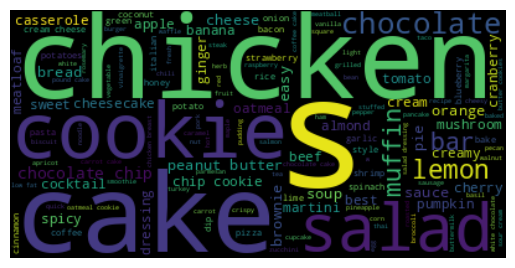

In [27]:
from wordcloud import WordCloud

# Read the whole text.
text = " ".join(recipes_df["name"].astype(str))

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Representing recipe names
rubric={points:3}

The next step is creating a representation of recipe names. 

**Your tasks:**

1. Similar to Exercise 1, create sentence embedding representation of recipe names (`name` column in `recipes_df`).  For the rest of the homework, we'll stick to the sentence embedding representation of recipe names.


> You might have to convert the recipe names to a list (`recipes_df["name"].tolist()`) for the embedder to work
> *If you create a dataframe with sentence embedding representation, set the index to `recipes_df.index` so that the indices match with the indices of the sample we are working with.*  
> **This might take a while to run.**


<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 3

In [29]:
embeddings = None
emb_recipes = embedder.encode(recipes_df["name"].tolist())
emb_rec_df = pd.DataFrame(emb_recipes, index=recipes_df.index)
embeddings = emb_rec_df
print(embeddings)
...

               0         1         2         3         4         5         6  \
42     -0.333474  0.227865 -0.307339  0.410549  0.917103 -0.345506  0.305811   
101    -0.024523  0.246223 -0.055708  0.358273  0.454786 -0.088054  0.260369   
129    -0.026562  0.194671  0.038102 -0.099181  0.653784 -0.230868  0.064516   
138    -0.168002 -0.219218  0.330761  0.302196 -0.173169  0.204557  0.192390   
163     0.061076 -0.333798  0.242906  0.395977 -0.466468  0.496505 -0.136754   
...          ...       ...       ...       ...       ...       ...       ...   
231430 -0.009714  0.200162  0.018329  0.237816  0.748988  0.121919  0.087918   
231514 -0.106532 -0.034574  0.160071  0.258504  0.882480  0.091899  0.008815   
231547  0.016149 -0.053035 -0.035097 -0.021836  0.735161  0.245519 -0.151837   
231596  0.026659  0.202483  0.344633 -0.138708  0.514424  0.630948 -0.003165   
231629 -0.031947 -0.258190 -0.079766 -0.507932 -0.155580  0.635225 -0.127390   

               7         8         9  .

Ellipsis

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 3: Clustering recipe names
<hr>

In this exercise you'll cluster recipe names with some of the clustering algorithms we have seen in class. This will also involve making some attempts to pick reasonable hyperparameter values for each clustering method based on the quality of the resulting clusters. For example, for KMeans, you need to specify the number of clusters in advance, which is often challenging on real-world datasets. For DBSCAN, you need to pick appropriate `eps` and `min_samples`. For hierarchical clustering, you need to pick a suitable linkage criterion, distance metric, and prune the tree so that it's possible to visualize and interpret it. 

Here are some methods which may help you with picking reasonable values for the hyperparameters. 
- Visualize the Elbow plot (KMeans). 
- Visualize Silhouette plots. 
- Visualize resulting clusters using `plot_umap_clusters` function from Exercise 1. 
- Sample some recipes from each cluster, manually inspect whether there are coherent semantic themes. (For this, you may use the function `print_clusters` given below.) 
        
> You may use the [`yellowbrick`](https://www.scikit-yb.org/en/latest/) package for visualizing the Elbow plot and the Silhouette plots. You can intall it with

```conda install -c districtdatalabs yellowbrick```

**Note that the process of picking reasonable hyperparameter values will be exploratory, iterative, and will involve manual inspection and judgment, as there is no ground truth to verify how well the model is doing. In your solutions, please do not include everything you try. Only present the results of the most informative trials. Add a narrative to your answer so that it's easy for the grader to follow your choices and reasoning.** 

In [30]:
def print_clusters(recipes_df, cluster_labels, n_recipes=10, replace=False, random_state=None):
    """
    Given recipes_df containing recipe names and cluster assignment (labels), 
    sample and print n_recipes recipes per cluster. 

    Parameters
    -----------
    recipe_df : pandas dataframe 
        recipes dataframe containing recipe names in the "name" column
    cluster_labels : ndarray or a list
        cluster labels for each row in recipes_df 
    n_recipes : int
        number of examples to sample from each cluster
    replace: bool
        replace flag to pass to the sampling of recipe names

    Returns
    -----------
    None
    """    
    
    grouped = (
        pd.DataFrame(
            {
                "name": recipes_df["name"],
                "cluster_label": cluster_labels,
            }
        )
        .sort_values("cluster_label")
        .groupby("cluster_label")    
    )
    
    for name, group in grouped:
        print(f"Cluster {name}")        
        print(("----------").format(""))        
        print("\n".join(group.sample(n_recipes, random_state=random_state)['name'].tolist()))
        print("\n\n")

<br><br>

<!-- BEGIN QUESTION -->

### 3.1 K-Means
rubric={points:6}

**Your tasks:**

1. Cluster recipe titles using KMeans. Make some attempts to determine the optimal number of clusters. 
2. Pick one or two best models and justify your choice. 

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

In [31]:
from yellowbrick.cluster import KElbowVisualizer



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

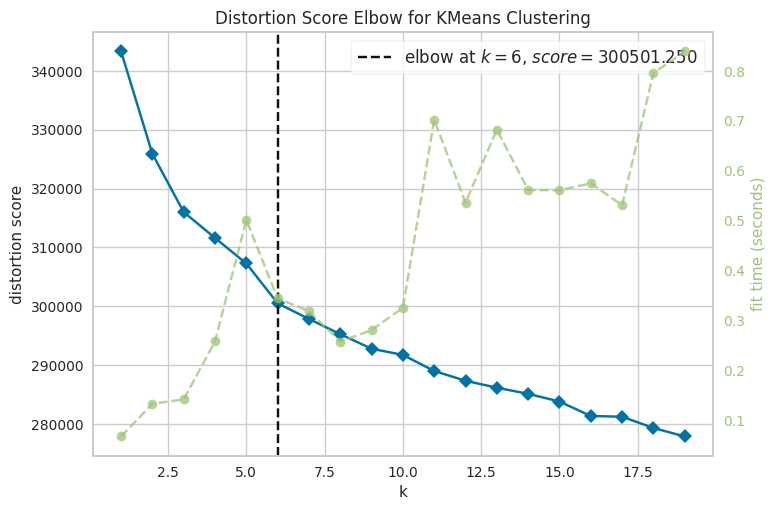

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
# We can pick n=6 because from 1-20 we see that the elbow lies at 6

In [36]:
num_clusters = 6  # Replace with the actual number of clusters
kmeans_recp = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_recp.fit(embeddings)


KMeans(n_clusters=6, n_init=10, random_state=42)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

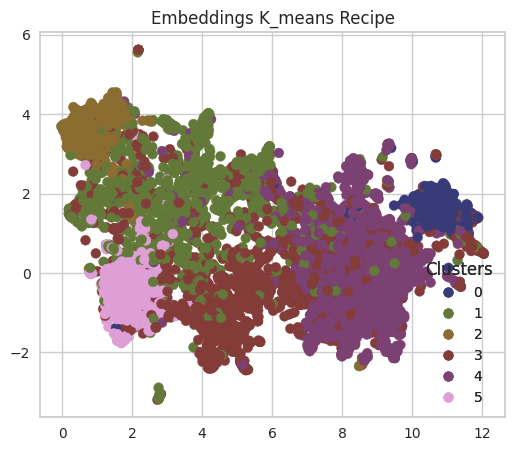

In [37]:
plot_umap_clusters(
    embeddings,
    kmeans_recp.labels_,
    title="Embeddings K_means Recipe"
)

In [ ]:
...

<!-- END QUESTION -->

<br><br><br><br>

<!-- BEGIN QUESTION -->

### 3.2 DBSCAN
rubric={points:6}

**Your tasks:**

1. Cluster recipe names using `DBSCAN` with `metric="cosine"`. Make some attempts to tune the  hyperparameters `eps` and `min_samples`. 

<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

In [132]:
from yellowbrick.cluster import SilhouetteVisualizer

my_arr = np.arange(0.1, 1, 0.1)

# for i in my_arr:
#     for s in range(1,5):
#         dbscan_rec = DBSCAN(eps=i, min_samples=s, metric="cosine")  
#         dbscan_rec.fit(embeddings)


#         n_clusters = len(set(dbscan_rec.labels_))
#         print(n_clusters)

dbscan_rec = DBSCAN(eps=0.05, min_samples=2, metric="cosine")  
dbscan_rec.fit(embeddings)


n_clusters = len(set(dbscan_rec.labels_))
print(n_clusters)

18


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

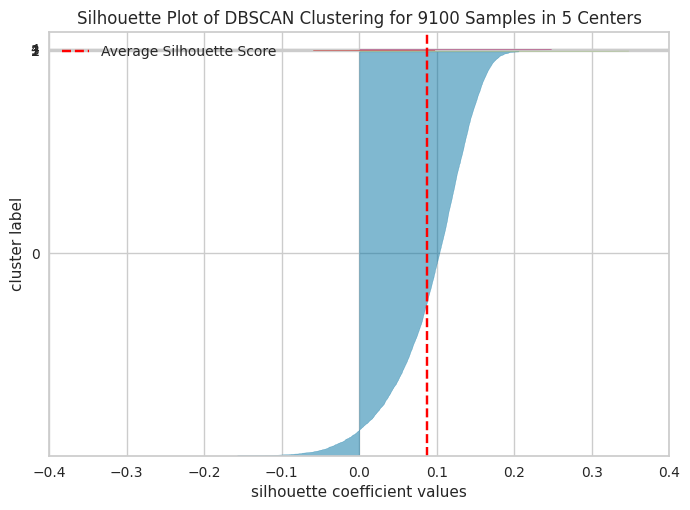

In [117]:
dbscan_rec.n_clusters = n_clusters
dbscan_rec.predict = lambda x: dbscan_rec.labels_
visualizer = SilhouetteVisualizer(dbscan_rec, colors="yellowbrick")
visualizer.fit(embeddings)  # Fit the data to the visualizer
visualizer.show();

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

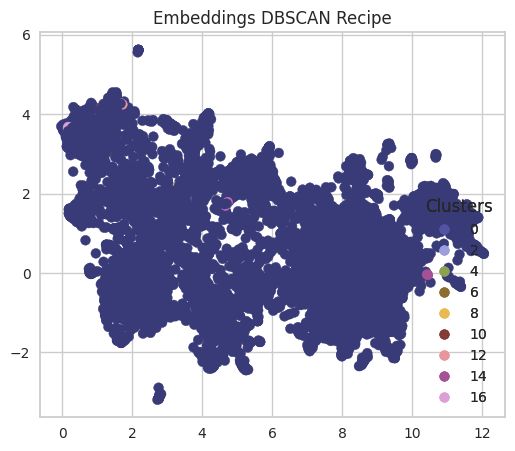

In [133]:
plot_umap_clusters(
    embeddings,
    dbscan_rec.labels_,
    title="Embeddings DBSCAN Recipe"
)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Hierarchical clustering
rubric={points:6}

**Your tasks:**

1. Try hierarchical clustering with `metric="cosine"` on this problem. Show a dendrogram by using a suitable truncation method. 
2. Create flat clusters by cutting the tree at the appropriate level. 

> *Note: Try orientation="left" of `dendrogram` for better readability of the dendrogram.*

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.4 Manual interpretation of clusters
rubric={points:6}

**Your tasks:**

1. Label the topics/themes you see in the clusters created by different clustering methods.  
2. Do you see a common theme across clusters created by different clustering methods? Do you see any differences between the clusters created by different clustering methods? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br><br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)